In [3]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 3.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=592e2a859f7092aa3df4cac1645dfa200a534a3cfda91d6c6f8c6d3f6324bd0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nijyd3tj/wheels/df/e1/fb/84d69cb87032ee4f92e69746bc6813e723c4ee0211a8b75deb
Successfully built grad-cam


In [2]:
import pandas as pd

metadata = pd.read_csv("/home/satvik/corona_detection/Chest_xray_Corona_Metadata.csv")
base_path = "/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
train_dir = f"{base_path}/train/"
test_dir = f"{base_path}/test/"

metadata['Full_Image_Path'] = metadata.apply(
    lambda row: f"{train_dir}{row['X_ray_image_name']}" if row['Dataset_type'] == 'TRAIN' else f"{test_dir}{row['X_ray_image_name']}",
    axis=1
)

train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']

train_paths = train_data['Full_Image_Path'].tolist()
train_labels = train_data['Label'].tolist()

test_paths = test_data['Full_Image_Path'].tolist()
test_labels = test_data['Label'].tolist()

print("Train set size:", len(train_paths))
print("Test set size:", len(test_paths))

print("Sample train paths and labels:", list(zip(train_paths[:5], train_labels[:5])))
print("Sample test paths and labels:", list(zip(test_paths[:5], test_labels[:5])))

Train set size: 5286
Test set size: 624
Sample train paths and labels: [('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg', 'Normal'), ('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0127-0001.jpeg', 'Normal'), ('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0125-0001.jpeg', 'Normal'), ('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0122-0001.jpeg', 'Normal'), ('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0119-0001.jpeg', 'Normal')]
Sample test paths and labels: [('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0021-0001.jpeg', 'Normal'), ('/home/satvik/corona_detection/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0019-0001.jpeg', 'Normal

In [20]:
# Check what the train_loader contains by fetching one batch of data
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)  # (batch_size, channels, height, width)
    print("Batch of labels:", labels)
    break  # Only print the first batch


Batch of images shape: torch.Size([8, 1, 224, 224])
Batch of labels: ('Normal', 'Pnemonia', 'Normal', 'Pnemonia', 'Pnemonia', 'Normal', 'Pnemonia', 'Pnemonia')


In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) 
    ])
}

from sklearn.preprocessing import LabelEncoder

# Create and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(metadata['Label'])  # Fit on all labels to ensure consistent encoding

# Convert string labels to numeric
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Print the encoding mapping for reference
print("Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

class XRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to the images.
            labels (list): List of encoded (numeric) labels corresponding to the images.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.image_paths = image_paths
        self.labels = labels  # Labels are already encoded
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]  # Already numeric

        return image, label

# Create datasets with encoded labels
train_dataset = XRayDataset(train_paths, train_labels_encoded, transform=image_transforms['train'])
test_dataset = XRayDataset(test_paths, test_labels_encoded, transform=image_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Label encoding mapping:
Normal -> 0
Pnemonia -> 1


In [4]:
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        flattened_size = 64 * 56 * 56
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(metadata['Label'].unique())
model = SimpleCNN(num_classes)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [39]:
# Add this before the training loop to inspect the data structure
for batch in train_loader:
    print("Type of batch:", type(batch))
    print("Length of batch:", len(batch))
    print("Type of first element:", type(batch[0]))
    print("Type of second element:", type(batch[1]))
    break

Type of batch: <class 'list'>
Length of batch: 2
Type of first element: <class 'torch.Tensor'>
Type of second element: <class 'torch.Tensor'>


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 1/10 - Loss: 0.2583, Accuracy: 0.9016


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.96      0.38      0.55       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.69      0.69       624
weighted avg       0.81      0.76      0.73       624



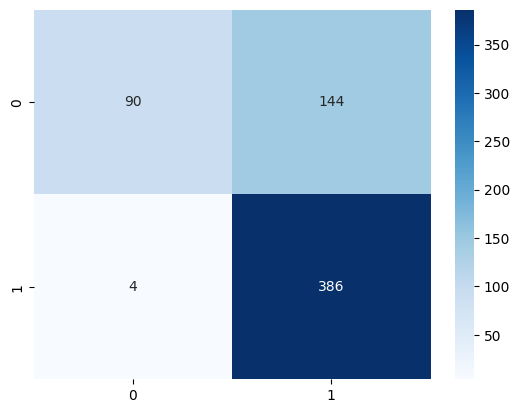

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 2/10 - Loss: 0.1428, Accuracy: 0.9480


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.89      0.62      0.73       234
           1       0.81      0.95      0.88       390

    accuracy                           0.83       624
   macro avg       0.85      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624



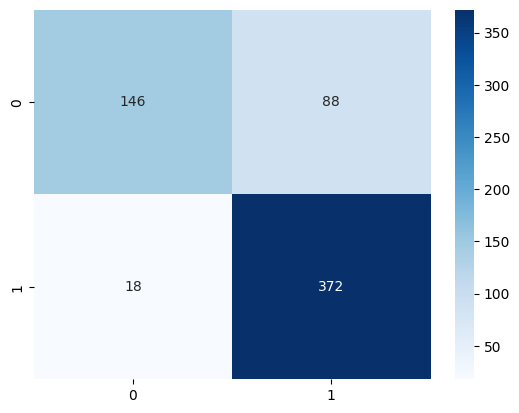

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 3/10 - Loss: 0.1272, Accuracy: 0.9538


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.92      0.41      0.56       234
           1       0.73      0.98      0.84       390

    accuracy                           0.76       624
   macro avg       0.83      0.69      0.70       624
weighted avg       0.80      0.76      0.74       624



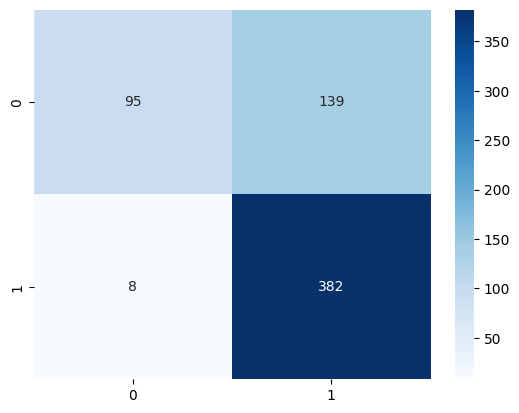

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 4/10 - Loss: 0.1186, Accuracy: 0.9588


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.85      0.57      0.68       234
           1       0.78      0.94      0.86       390

    accuracy                           0.80       624
   macro avg       0.82      0.75      0.77       624
weighted avg       0.81      0.80      0.79       624



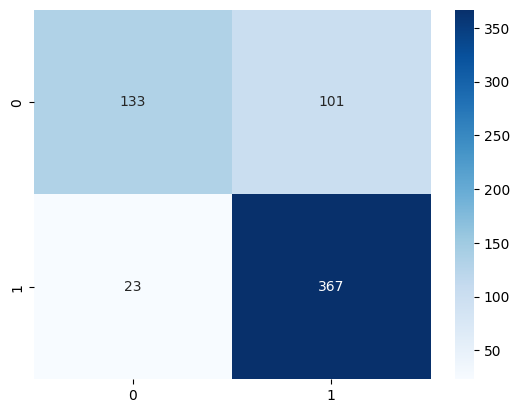

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 5/10 - Loss: 0.1001, Accuracy: 0.9612


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.89      0.50      0.64       234
           1       0.76      0.96      0.85       390

    accuracy                           0.79       624
   macro avg       0.82      0.73      0.74       624
weighted avg       0.81      0.79      0.77       624



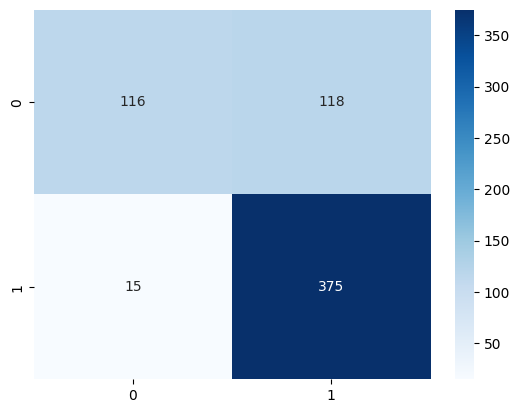

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 6/10 - Loss: 0.1041, Accuracy: 0.9625


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.89      0.44      0.59       234
           1       0.74      0.97      0.84       390

    accuracy                           0.77       624
   macro avg       0.82      0.71      0.72       624
weighted avg       0.80      0.77      0.75       624



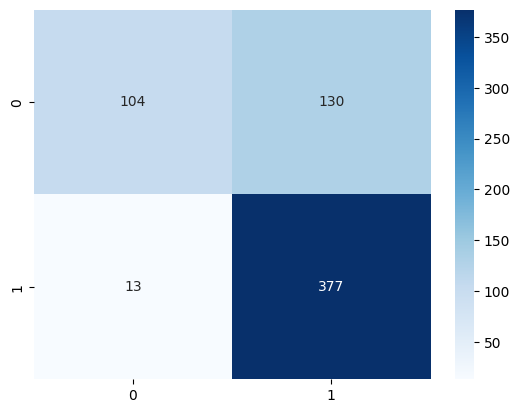

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 7/10 - Loss: 0.0951, Accuracy: 0.9661


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.96      0.32      0.48       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.65       624
weighted avg       0.80      0.74      0.70       624



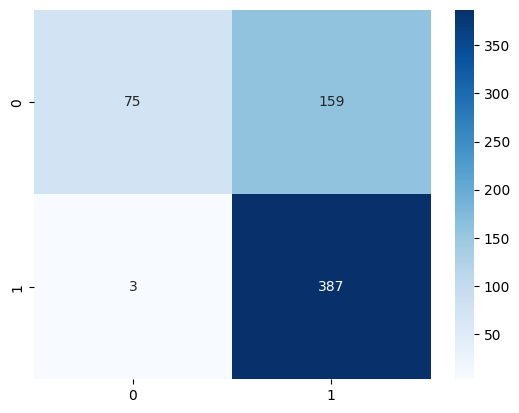

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 8/10 - Loss: 0.0934, Accuracy: 0.9648


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.99      0.32      0.49       234
           1       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.66      0.66       624
weighted avg       0.81      0.75      0.70       624



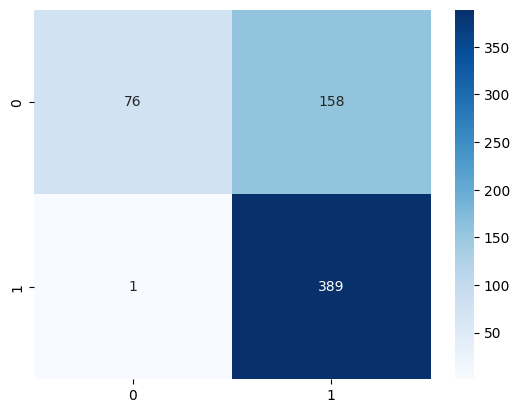

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 9/10 - Loss: 0.0810, Accuracy: 0.9701


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.99      0.31      0.47       234
           1       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624



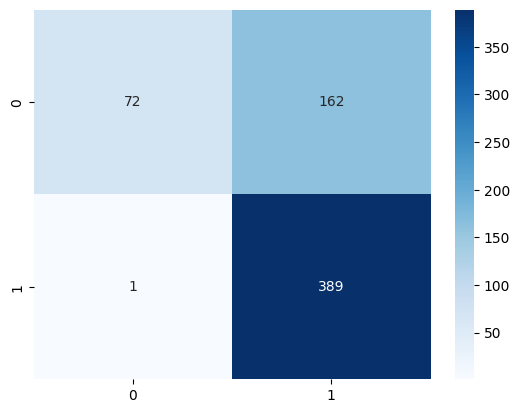

/tmp/ipykernel_207466/2699388934.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


Epoch 10/10 - Loss: 0.0821, Accuracy: 0.9709


/tmp/ipykernel_207466/2699388934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.long)


              precision    recall  f1-score   support

           0       0.97      0.44      0.61       234
           1       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



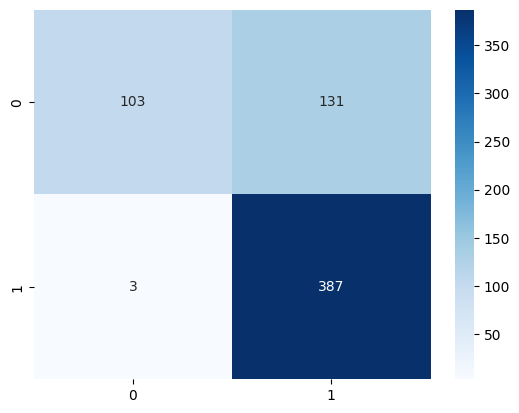

Model saved to simple_cnn.pth
Training complete


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torch.utils.data import DataLoader

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            # Unpack batch and convert labels to tensor
            images = batch[0]
            labels = torch.tensor(batch[1], dtype=torch.long)
            
            # Move to device
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
                
    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

def train_model(model, train_loader, test_loader, num_epochs, device, learning_rate=0.001, save_path="model.pth"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            # Unpack batch and convert labels to tensor
            images = batch[0]
            labels = torch.tensor(batch[1], dtype=torch.long)
            
            # Move to device
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
        # Evaluate on the test set after each epoch
        evaluate_model(model, test_loader, device)

    # Save the model after training
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    print("Training complete")

# Initialize model and training
num_classes = len(metadata['Label'].unique())
model = SimpleCNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, test_loader, num_epochs=10, device=device, save_path="simple_cnn.pth")


In [14]:
for batch in train_loader:
    images, labels = batch
    print((images[0]))
    break

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


In [16]:
!pip install torchviz 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [24]:
from torchviz import make_dot

model = SimpleCNN(num_classes=2)

# Load the state dictionary
state_dict = torch.load("/home/satvik/corona_detection/simple_cnn.pth")

# Check and ensure the state_dict is loaded into the model
if isinstance(state_dict, dict):  # If it's a state_dict
    model.load_state_dict(state_dict)
else:
    model = state_dict  

/tmp/ipykernel_207466/3292628750.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/satvik/corona_detection/simple_cnn.pth")


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Prepare a single image for visualization
for batch in train_loader:
    images, labels = batch
    image = images[0].unsqueeze(0).to(device)  # Get the first image
    break

# Forward pass
output = model(image)

# Visualize the model's computation graph
make_dot(output, params=dict(model.named_parameters())).render("model_graph", format="png")

'model_graph.png'

In [20]:
!pip install torchsummary 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Visualizing filters of first Conv2d (1 -> 32 channels):


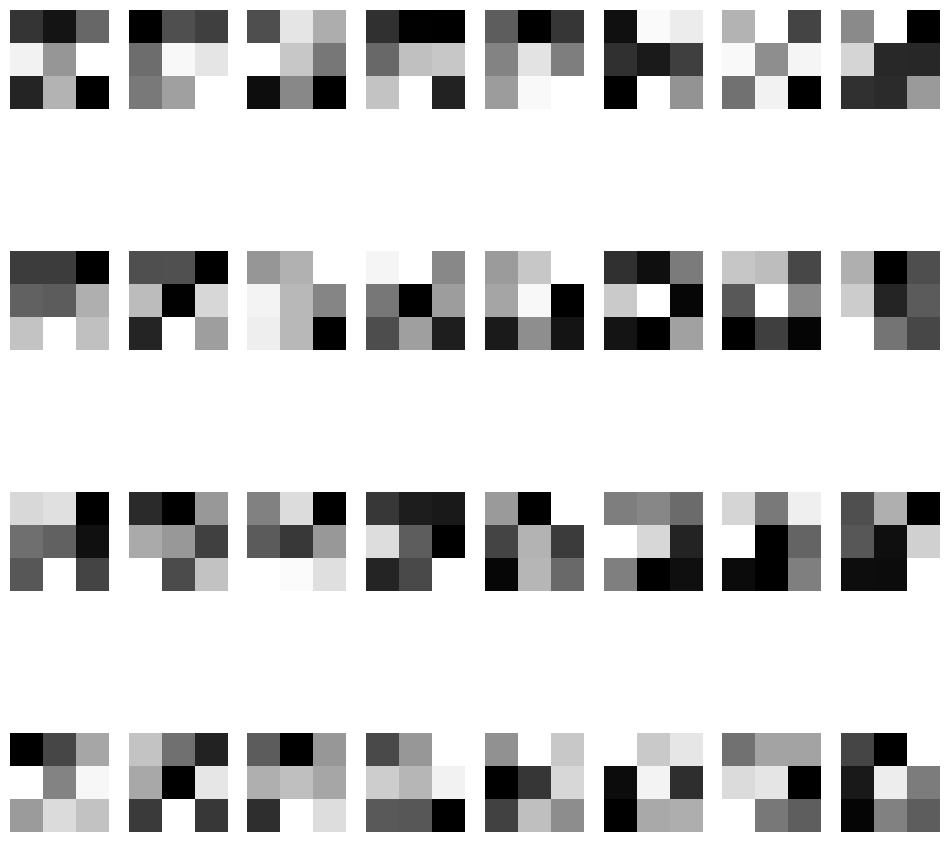

Visualizing filters of second Conv2d (32 -> 64 channels):


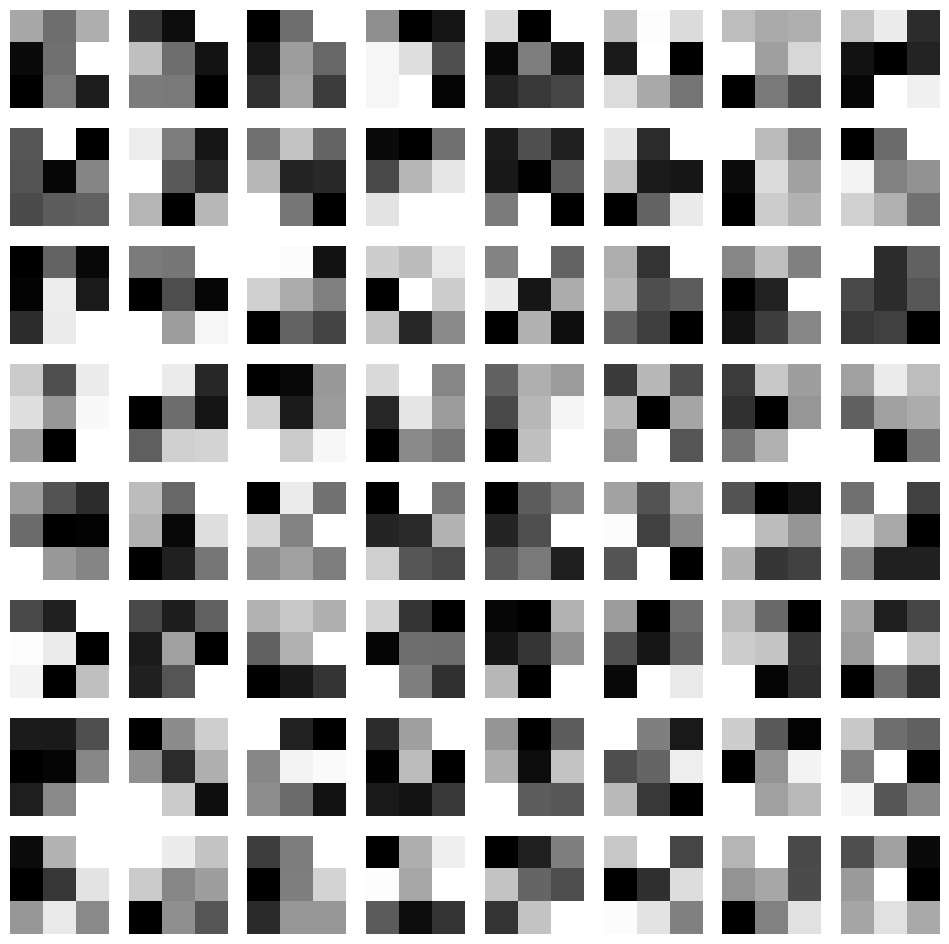

In [29]:
import torch
import matplotlib.pyplot as plt

# Assuming your model is loaded as `model`
# Get the weights from the convolutional layers
conv1_weights = model.features[0].weight.data.cpu().numpy()  # First Conv2d(1, 32)
conv2_weights = model.features[3].weight.data.cpu().numpy()  # Second Conv2d(32, 64)

# Function to visualize filters
def visualize_filters(filters, num_columns=8):
    num_filters = filters.shape[0]
    num_rows = (num_filters + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')

    # Hide unused axes
    for i in range(num_filters, len(axes)):
        axes[i].axis('off')

    plt.show()

# Visualize the filters
print("Visualizing filters of first Conv2d (1 -> 32 channels):")
visualize_filters(conv1_weights)

print("Visualizing filters of second Conv2d (32 -> 64 channels):")
visualize_filters(conv2_weights)
